In [95]:
import xml.etree.ElementTree as ET
import pandas as pd

In [27]:
def get_lane_length(df_lanelength): #get lane length information
    lanelength_data = pd.read_csv(df_lanelength, skiprows=1, header=None) 
    lane_list = lanelength_data[0]
    length_list = lanelength_data[1]/1000
    #store in dictionary : 
    lane_length = dict(zip(lane_list,length_list))
    return lane_length

In [17]:
def get_data_group(df_flow_and_density): #grouping data to pandas object
    #get flow(veh/hr) and density(veh/km) in each lane for certain interval 
    flowdensity = df_flow_and_density

    #only for get a list of 'time' in mfd-data.csv
    flowdensity_lane = flowdensity.groupby('lane_ids')
    dummy_group = flowdensity_lane.get_group('1_0')
    time_list = dummy_group['time']

    #real grouping (group by time)
    flowdensity_time = flowdensity.groupby('time')
    return time_list, flowdensity_time

In [97]:
def get_MFD_property(time_list, flowdensity_time,total_lane_length,lane_length_dict): #calculate Qt and Kt
    Q = [] #list of network flow
    K = [] #list of network density
    #calculate network flow (Qt) and network density(Kt)
    for time in time_list:
        the_group = flowdensity_time.get_group(time)
        lane_ids = the_group['lane_ids']
        lane_flows = the_group['outflow']
        lane_densities = the_group['laneDensity']
        flowx = []
        densityx= []
        #bisa dibenerin tanpa enumerate 
        for i,lane in enumerate(lane_ids):
            lane_id = lane_ids.iloc[i]
            lane_flow = lane_flows.iloc[i]
            lane_densities = lane_densities.astype(float)
            lane_density = lane_densities.iloc[i]
            lane_length = lane_length_dict[str(lane_id)] #get lane length from earlier dictionary in lane-length.csv
        
            flowxlength = lane_flow*lane_length
            flowx.append(flowxlength) #list
            densityxlength = lane_density*lane_length
            densityx.append(densityxlength) #list
        Qt = sum(flowx)/total_lane_length
        Kt = sum(densityx)/total_lane_length
        Q.append(Qt)
        K.append(Kt)
    return Q, K

In [8]:
def convert(n):
    return str(datetime.timedelta(seconds = n))

In [28]:
csv_lanelength = 'lane-length-new.csv'
# csv_list = ['Tes_DQN_1.csv']

lane_length_dict = get_lane_length(csv_lanelength)
total_lane_length = sum(lane_length_dict.values()) #total lane length in network (KM)

In [1]:
# Define a list to store the data
data = []
tree = ET.parse('net_jkt-new/output/lane-data.xml')
root = tree.getroot()

# Iterate over all "interval" elements in the root
for interval in root:
    # Get the attributes of the interval
    interval_attribs = interval.attrib
    
    # Iterate over all "edge" elements in the interval
    for edge in interval:
        # Get the attributes of the edge
        edge_attribs = edge.attrib
        
        # Iterate over all "lane" elements in the edge
        for lane in edge:
            # Get the attributes of the lane
            lane_attribs = lane.attrib
            
            # Combine the attributes of the interval, edge, and lane
            combined_attribs = {**interval_attribs, **edge_attribs, **lane_attribs}
            
            # Append the combined attributes to the data list
            data.append(combined_attribs)

# Convert the data list to a DataFrame
df = pd.DataFrame(data)

In [2]:
df = pd.DataFrame(data)

df['departed'] = df['departed'].astype(int)
df['entered'] = df['entered'].astype(int)
df['arrived'] = df['arrived'].astype(int)
df['left'] = df['left'].astype(int)

df['inflow'] = (df['departed'] + df['entered']) * 12
df['outflow'] = (df['arrived'] + df['left']) * 12

df = df[['begin', 'id', 'laneDensity', 'inflow', 'outflow']]

# Rename "begin" column to "time" and id column to "lane_ids"
df = df.rename(columns={'begin': 'time', 'id': 'lane_ids'})

In [3]:
df

,time,lane_ids,laneDensity,inflow,outflow
0,28800.00,1_0,5.99,132,120
1,28800.00,1_1,12.58,276,264
2,28800.00,10_0,12.64,120,168
3,28800.00,10_1,11.73,264,192
4,28800.00,100_0,0.74,24,12
...,...,...,...,...,...
582,28800.00,gneE397_1,NaN,0,0
583,28800.00,gneE401_0,NaN,0,0
584,28800.00,gneE401_1,54.83,228,228
585,28800.00,gneE401_2,NaN,0,0


In [4]:
df = df.dropna()

In [100]:
time_list = {}
flowdensity_time = {}
Qn = {}
Kn = {}

In [101]:
time_list, flowdensity_time = get_data_group(df)

In [103]:
Qn, Kn = get_MFD_property(time_list,flowdensity_time,total_lane_length,lane_length_dict)

In [104]:
Qn

[43.96427128439204]

In [105]:
Kn

[3.211306413781152]

In [106]:
import matplotlib.pyplot as plt

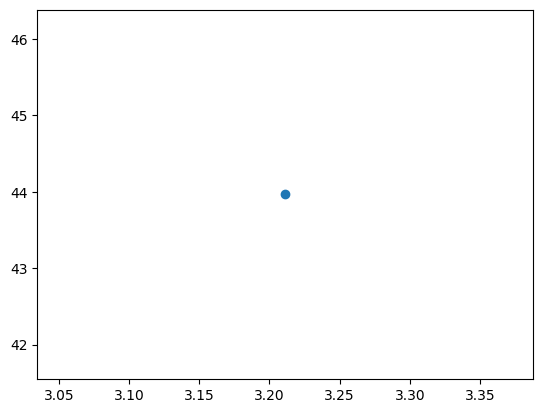

In [110]:
plt.plot(Kn, Qn, 'o')
plt.show()